In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
import gzip
import plotly.express as px
import folium
import geopandas as gpd
import contextily as ctx
import math
import random
from collections import defaultdict



In [17]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

In [18]:
meta = [item for item in parse('meta-California.json.gz')]
meta_df = pd.DataFrame(meta)

In [19]:
rating_df = pd.read_csv('rating-California.csv.gz', compression='gzip')

In [56]:
rating_df.head()

,business,user,rating,timestamp
6,0x80c2c778e3b73d33:0xbdc58662a4a97d49,107889750495339695586,5,1623536126668
7,0x80c2c778e3b73d33:0xbdc58662a4a97d49,108991152262655788985,5,1609909927056
8,0x80c2c778e3b73d33:0xbdc58662a4a97d49,111290322219796215751,5,1612849648663
9,0x80c2c778e3b73d33:0xbdc58662a4a97d49,112640357449611959087,4,1583643882296
10,0x80c2c778e3b73d33:0xbdc58662a4a97d49,117440349723823658676,5,1551938216355


In [57]:
meta_df.head()

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,City Textile,"City Textile, 3001 E Pico Blvd, Los Angeles, C...",0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,None,34.018891,-118.215290,[Textile exporter],4.5,6,None,None,None,Open now,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...
1,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",0x80c2c778e3b73d33:0xbdc58662a4a97d49,None,34.058092,-118.292130,[Korean restaurant],4.4,18,None,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...","{'Service options': ['Takeout', 'Dine-in', 'De...",Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...
2,Nova Fabrics,"Nova Fabrics, 2200 E 11th St, Los Angeles, CA ...",0x80c2c89923b27a41:0x32041559418d447,None,34.023669,-118.232930,[Fabric store],3.3,6,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...","{'Service options': ['In-store shopping'], 'Pa...",Open ⋅ Closes 5PM,"[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...
3,Nobel Textile Co,"Nobel Textile Co, 719 E 9th St, Los Angeles, C...",0x80c2c632f933b073:0xc31785961fe826a6,None,34.036694,-118.249421,[Fabric store],4.3,7,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",{'Service options': ['In-store pickup']},Open ⋅ Closes 5PM,"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...
4,Matrix International Textiles,"Matrix International Textiles, 1363 S Bonnie B...",0x80c2cf163db6bc89:0x219484e2edbcfa41,None,34.015505,-118.181839,[Fabric store],3.5,6,None,"[[Thursday, 8:30AM–5:30PM], [Friday, 8:30AM–5:...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 5:30PM,"[0x80c2cf042a5d9561:0xd0024ad6f81f1335, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...


In [23]:
# Removing all non-restaurant businesses from the rating_df
meta_df_restaurants = meta_df[meta_df['category'].apply(lambda categories: any('restaurant' in category.lower() for category in categories) if categories is not None else False)]

restaurant_ids = meta_df_restaurants['gmap_id'].tolist()

rating_df = rating_df[rating_df['business'].isin(restaurant_ids)]

92671


In [58]:
rating_df.shape

(29563164, 4)

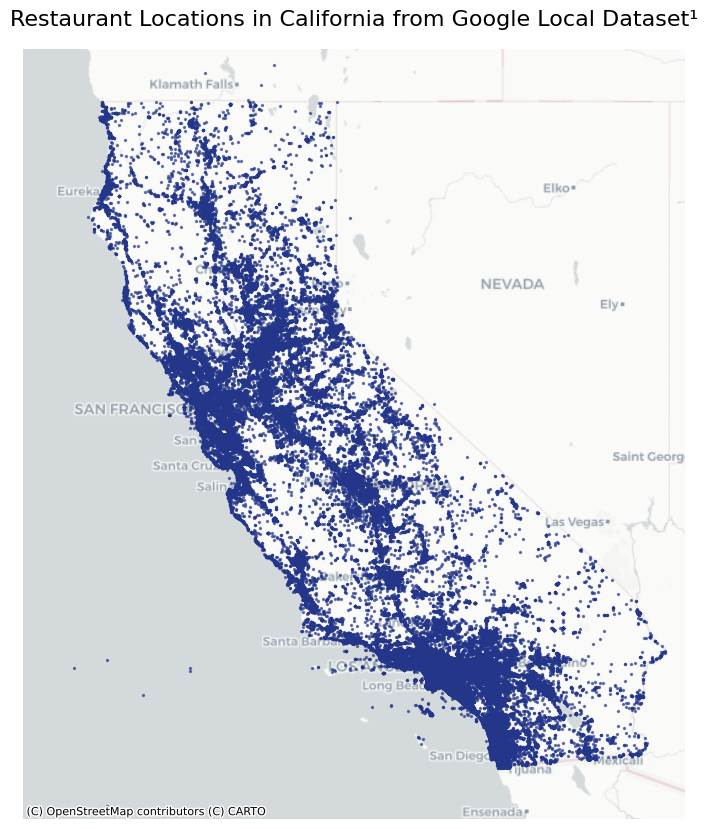

In [43]:
gdf = gpd.GeoDataFrame(
    meta_df, geometry=gpd.points_from_xy(meta_df.longitude, meta_df.latitude))

# Set the CRS for GeoDataFrame to EPSG:4326
gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(epsg=3857)

# Define bounds for California (in Web Mercator coordinates)
california_bounds = {
    "minx": -13884029 - 100000, # Corresponding to the westernmost point
    "miny": 3832058 - 100000,   # Corresponding to the southernmost point
    "maxx": -12765716 + 100000, # Corresponding to the easternmost point
    "maxy": 5165920 + 100000    # Corresponding to the northernmost point
}

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the points
gdf.plot(ax=ax, color='#24368a', alpha=0.6, markersize=2)

# Add a basemap with higher zoom level
# Adjust the zoom level as needed for better resolution
tile_source = ctx.providers.CartoDB.Positron
ctx.add_basemap(ax, crs=gdf.crs, source=tile_source, zoom=6)

# Zoom into California
ax.set_xlim(california_bounds['minx'], california_bounds['maxx'])
ax.set_ylim(california_bounds['miny'], california_bounds['maxy'])

ax.set_axis_off()
plt.title('Restaurant Locations in California from Google Local Dataset' + u'\u00b9', fontsize=16)
plt.show()



In [46]:
# Setting up evaluation metrics - Mean Squared Error and Root Mean Squared Error
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [47]:
# Splitting the dataset into train and test sets
from sklearn.model_selection import train_test_split

X = rating_df.drop('rating', axis=1)
y = rating_df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
X_train

,business,user,timestamp
34183946,0x808fc92442fa48a1:0x572054755648186b,109553316867725526218,1505705002142
28554548,0x80dcd8ac9e23d14b:0x10a65acc75428980,114485281206511212808,1501892725203
66774837,0x80c2d7d5c8e7cc29:0xbd068fe81fc3b5ec,115622989591644514679,1499868652370
33523324,0x80c2b7dd72aee2c5:0xd10906a54fda556b,107860450156670118255,1456113975887
55139327,0x80dce087f991179f:0x18e7eea9642fda34,101102961610602443726,1612838588630
...,...,...,...
52419656,0x80d9543c9684bd97:0x74aa488d31484806,101935099307277451534,1453429946427
63782548,0x80c2cd82698dacb7:0x4c2fb5d51b1b8242,111609969627018441029,1581915714542
56712716,0x80c2b72e1209a111:0xc6108acb4fcd6dd6,105149783804973604032,1521244292002
42962654,0x808f86f29143468d:0x19f4e304d96af41b,116679176520246562076,1614142900900


# Baselines

### Global Mean

In [53]:
# Calculate the global mean of all ratings in the training set
global_mean = y_train.mean()

print(f'Global Mean: ' + str(global_mean))

Global Mean: 4.229640171715383


In [54]:
# Use the global mean as the prediction for all instances in the test set
y_pred = np.full(y_test.shape, global_mean)

In [55]:
# Calculate MSE
mse_value = mse(y_test, y_pred)
print(f'MSE: {mse_value}')

# Calculate RMSE
rmse_value = rmse(y_test, y_pred)
print(f'RMSE: {rmse_value}')

MSE: 1.335464014281811
RMSE: 1.1556227820019


### User Mean

In [60]:
# Create a DataFrame from X_train and y_train
train_df = X_train.copy()
train_df['rating'] = y_train

# Calculate the mean rating for each user
mean_ratings = train_df.groupby('user')['rating'].mean()

# Map the mean ratings to the users in the test set to create the predictions
y_pred = X_test['user'].map(mean_ratings)

# Fill any missing predictions with the global mean
y_pred = y_pred.fillna(global_mean)

In [61]:
# Calculate MSE
mse_value = mse(y_test, y_pred)
print(f'MSE: {mse_value}')

# Calculate RMSE
rmse_value = rmse(y_test, y_pred)
print(f'RMSE: {rmse_value}')

MSE: 1.2681508624218651
RMSE: 1.1261220459709795


### Restaurant (Item) Mean

In [62]:
# Calculate the mean rating for each restaurant
mean_ratings = train_df.groupby('business')['rating'].mean()

# Map the mean ratings to the users in the test set to create the predictions
y_pred = X_test['business'].map(mean_ratings)

# Fill any missing predictions with the global mean
y_pred = y_pred.fillna(global_mean)

In [63]:
# Calculate MSE
mse_value = mse(y_test, y_pred)
print(f'MSE: {mse_value}')

# Calculate RMSE
rmse_value = rmse(y_test, y_pred)
print(f'RMSE: {rmse_value}')

MSE: 1.2448504110636522
RMSE: 1.1157286458022184


### User KNN

In [73]:
usersPerItem = defaultdict(set) # Maps an item to the users who rated it
itemsPerUser = defaultdict(set) # Maps a user to the items that they rated
itemNames = {}
ratingDict = {} # To retrieve a rating for a specific user/item pair

for d in rating_df.to_dict(orient='records'):
    user,item = d['user'], d['business']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    ratingDict[(user,item)] = d['rating']
    itemNames[item] = meta_df[meta_df['gmap_id'] == item]['name'].values[0]

KeyboardInterrupt: 

### Biased MF

In [65]:
rating_df['rating'].max()

5

In [66]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

# Define a Reader object
# The Reader object helps in parsing the file or dataframe
reader = Reader(rating_scale=(1, 5))

# Create the dataset to be used for building the filter
data = Dataset.load_from_df(rating_df[['user', 'business', 'rating']], reader)

# Split data to train and test
trainset, testset = train_test_split(data, test_size=.25)

# Use the SVD algorithm
algo = SVD()

# Fit on the trainset
algo.fit(trainset)

# Predict ratings for the testset
predictions = algo.test(testset)

KeyboardInterrupt: 